## Compare datasets
Compares NASS county totals with values seen in the EWG dataset

In [59]:
import pandas as pd
%matplotlib inline

In [26]:
dfEWG = pd.read_excel('../data/raw/EWG_Poultry_wPot.xlsx',sheet_name='EWG_Poultry')
dfDEQ = pd.read_excel('../data/raw/EWG_Poultry_wPot.xlsx',sheet_name='DEQ poutlry ')
dfNASS = pd.read_csv('../data/processed/CHICKENS_2017.csv',index_col='county_name')

In [45]:
#Tally inventories
dfNASS['TotInventory'] = dfNASS[['CHICKENS, BROILERS - INVENTORY',
                                 'CHICKENS, LAYERS - INVENTORY',
                                 'CHICKENS, PULLETS, REPLACEMENT - INVENTORY',
                                 'CHICKENS, ROOSTERS - INVENTORY']].sum(axis=1)

In [ ]:
#Summarize EWG & DEQ data on county
dfEWG_co = dfEWG.groupby('COUNTYNAME').agg({'BIRD_COUNT':'sum'})
dfDEQ_co = dfDEQ.groupby('County Name').agg({'Allowable Count':'sum'})

In [39]:
#Merge the two datsets
dfCombo1 = pd.merge(dfEWG_co,dfDEQ_co,how='outer',left_index=True,right_index=True)
dfCombo1.columns = ['EWG_counts','DEQ_counts']
#Capitalize county names
dfCombo1.set_index(dfCombo1.index.str.upper(),inplace=True)

In [43]:
#Merge to the NASS data
dfAll = pd.merge(dfCombo1,dfNASS,how='outer',left_index=True,right_index=True)
dfAll.to_csv('../data/processed/Poultry_AllData.csv',index_label ='County')

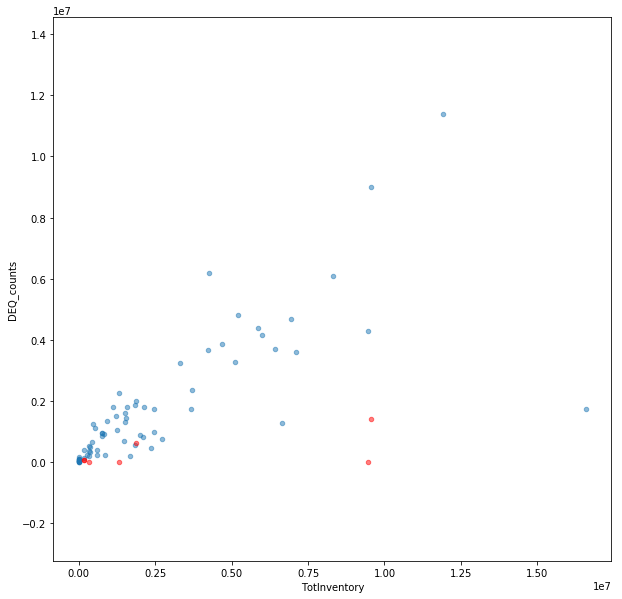

In [60]:
#Plot
ax = dfAll.plot(kind='scatter',
                x='TotInventory',
                y='EWG_counts',
                alpha=0.5,
                figsize=(10,10))
dfAll.plot(kind='scatter',
           x='TotInventory',
           y='DEQ_counts',
           color='red',
           alpha=0.5,
           ax=ax)
ax.axis('equal');